Implementamos el algoritmo SBS (sequential backward selection), usando un ejemplo del libro de Ratshka


In [0]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


#Creamos la clase que implementa el algoritmo

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.3, random_state=None):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score




In [2]:
#Cargamos los datos y transformamos el dataframe a OHE
#Importamos los datos de un fichero csv
import pandas as pd
df = pd.read_csv('ejemploMI.csv')
print(df.tail())

#Ahora realizamos el one-hot-encoding
df2=pd.get_dummies(df, drop_first=True)
print(df2.tail())

#Ahora guardamos el dataframe modificado en un fichero csv
df2.to_csv('ejemploMI_OHE.csv')

      Unnamed: 0     X  exitus  apache2 tipopaciente sexopac  edad  sofa  \
1360        1364  1364       0       24           QU  Hombre    68     5   
1361        1365  1365       0       18           QP  Hombre    55     5   
1362        1366  1366       0       13           QP  Hombre    68     2   
1363        1367  1367       0       10           QU  Hombre    33     1   
1364        1368  1368       0        8           QP  Hombre    64     4   

      lactato  
1360      1.9  
1361      1.5  
1362      4.9  
1363      1.1  
1364      4.8  
      Unnamed: 0     X  exitus  apache2  edad  sofa  lactato  tipopaciente_PT  \
1360        1364  1364       0       24    68     5      1.9                0   
1361        1365  1365       0       18    55     5      1.5                0   
1362        1366  1366       0       13    68     2      4.9                0   
1363        1367  1367       0       10    33     1      1.1                0   
1364        1368  1368       0        8   

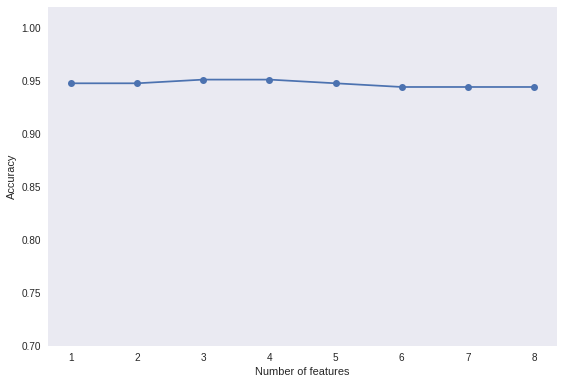

Mortalidad del grupo:  0.9362637362637363

(0, 1, 2, 3, 4, 5, 6, 7) :  0.9442508710801394
apache2 edad sofa lactato tipopaciente_PT tipopaciente_QP tipopaciente_QU sexopac_Mujer 
(0, 1, 2, 3, 4, 5, 6) :  0.9442508710801394
apache2 edad sofa lactato tipopaciente_PT tipopaciente_QP tipopaciente_QU 
(0, 1, 2, 3, 4, 5) :  0.9442508710801394
apache2 edad sofa lactato tipopaciente_PT tipopaciente_QP 
(0, 1, 2, 4, 5) :  0.9477351916376306
apache2 edad sofa tipopaciente_PT tipopaciente_QP 
(0, 1, 2, 4) :  0.9512195121951219
apache2 edad sofa tipopaciente_PT 
(0, 1, 2) :  0.9512195121951219
apache2 edad sofa 
(0, 2) :  0.9477351916376306
apache2 sofa 
(0,) :  0.9477351916376306
apache2 

In [124]:
#Ahora vamos a usarlo con nuestros datos y la implementación que hemos hecho en SVM

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Ahora añadimos variables al predictor

lasX3 = df2.iloc[:,[3,4,5,6,7,8,9,10]]  
laY3 = df2.iloc[:,2]


lasX3_train,lasX3_test,laY3_train,laY3_test = \
      train_test_split(lasX3,laY3,test_size=0.3,random_state=None,stratify=df2['exitus'].values)

sc = StandardScaler()
sc.fit(lasX3_train)
lasX3_train_std=sc.transform(lasX3_train)
lasX3_test_std=sc.transform(lasX3_test)

svm3 = SVC(kernel='rbf',C=1.0,random_state=None,gamma=0.1,probability=True)
svm3.fit(lasX3_train_std,laY3_train)

# selecting features
sbs = SBS(svm3, k_features=1)
sbs.fit(lasX3_train_std, laY3_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('images/04_08.png', dpi=300)
plt.show()

print("Mortalidad del grupo: ", 1-laY3.mean())

k3=sbs.subsets_
#print(len(sbs.subsets_))
for i in range(0,len(k3)):
    print('')
    print(k3[i],": ",sbs.scores_[i])
    for j in k3[i]:
        print(lasX3.columns[j],end=' ')


In [118]:
#Ahora usamos otro algoritmo de seleccion: RFE (recursive feature elimination)

from sklearn.feature_selection import RFE
svm4 = SVC(kernel="linear", C=0.1) # con rbf no puede hacerse
rfe = RFE(estimator=svm4, n_features_to_select=2, step=1)
rfe.fit(lasX3_train_std, laY3_train)
for j in range(0,len(lasX3.columns)):
  print(lasX3.columns[j],rfe.ranking_[j])


apache2 1
edad 4
sofa 5
lactato 1
tipopaciente_PT 7
tipopaciente_QP 3
tipopaciente_QU 6
sexopac_Mujer 2
